# Imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml

import torch.nn.functional as F

sys.path.append(os.path.abspath(os.path.join('..')))

import local_datasets
from torch.utils.data import DataLoader


import init_training

from tqdm import tqdm

from skimage.metrics import structural_similarity as ssim

import pickle

import pandas as pd
import seaborn as sns

# Setup

In [2]:
# change working directory if not /home/mappel/Dynaphos/viseon
if os.getcwd().split("/")[-1] != "viseon":
    os.chdir("/home/mappel/Dynaphos/viseon")

In [3]:
def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked

experiment_yaml = [ './_config/exp1-snellius/128x128_contrained_boundary.yaml',
                    './_config/exp1-snellius/lin64x64_contrained_boundary.yaml',
                    './_config/exp1-snellius/fov64x64_contrained_boundary.yaml',
                    './_config/exp1-snellius/lin32x32_contrained_boundary.yaml',
                    './_config/exp1-snellius/fov32x32_contrained_boundary.yaml',
                    './_config/exp1-snellius/lin16x16_contrained_boundary.yaml',
                    './_config/exp1-snellius/fov16x16_contrained_boundary.yaml']

# load configs into dict
config = [load_config(yaml_file) for yaml_file in experiment_yaml]
config = {key: value for key, value in zip(['128x128', '64x64lin', '64x64fov', '32x32lin', '32x32fov', '16x16lin', '16x16fov'], config)}

# Compare inputs

In [4]:
# example_images = []

# for experiment in config.keys():
#     cfg = config[experiment]
#     cfg['output_scaling'] = 256.0e-6
#     testset = local_datasets.get_lapa_dataset(cfg, split='test')
#     batch = next(iter(DataLoader(testset, batch_size=4)))
#     images = batch['image']

#     image_size = images.shape[-1]

#     background = torch.ones((images.shape[0], images.shape[1], 128, 128))
#     background[:,:,64-image_size//2:64+image_size//2,64-image_size//2:64+image_size//2] = images

#     example_images.append(background)

In [5]:
# example_images[0].shape

In [6]:
# # plot side by side
# titles = ['128 x 128', '64 x 64 linear', '64 x 64 foveated compression', 

# fig, ax = plt.subplots(4,3)
# # no whitespace
# fig.subplots_adjust(hspace=0, wspace=0)
# for i in range(3):
#     for j in range(4):
#         ax[j,i].imshow(example_images[i][j].permute(1,2,0).cpu())
#         if j == 0:
#             ax[j,i].set_title(titles[i], fontsize=9)
#         ax[j,i].axis('off')
# plt.show()

# Test

### All experiments

In [ ]:
# # calculate ssim and mse for all

# experiments = ['128x128', '64x64lin', '64x64fov', '32x32lin', '32x32fov', '16x16lin', '16x16fov']

# model_outputs_ = {}

# # save model_output for all 3 for one batch 

# for experiment in experiments:
#     cfg = config[experiment]
#     testset = local_datasets.get_lapa_dataset(cfg, split='test')
#     models = init_training.get_models(cfg)

#     models['encoder'].load_state_dict(torch.load(cfg['save_path'] + 'checkpoints/final_encoder.pth'))
#     models['decoder'].load_state_dict(torch.load(cfg['save_path'] + 'checkpoints/final_decoder.pth'))

#     # The forward function
#     training_pipeline = init_training.get_training_pipeline(cfg)

#     forward = training_pipeline['forward']
#     compound_loss_func = training_pipeline['compound_loss_func']

#     mse_phosphenes = []
#     ssim_phosphenes = []
#     mse_phosphene_image = []
#     ssim_phosphene_image = []
#     mse_reconstruction = []
#     ssim_reconstruction = []

#     # tqdm progress bar over dataloader
#     for batch in tqdm(DataLoader(testset, batch_size=4)):
#         with torch.no_grad():
#             model_output = forward(batch, models, cfg)

#             target_centers = model_output['target_centers'].cpu().numpy()
#             centers = model_output['phosphene_centers'].cpu().numpy()

#             phosphene_image = model_output['phosphenes'].cpu().numpy()
#             target_phosphene_image = model_output['target_phosphenes'].cpu().numpy()           

#             reconstruction = model_output['reconstruction'].cpu().numpy()
#             target = batch['contour'].cpu().numpy()

#             mse_phosphene_image.extend([F.mse_loss(torch.tensor(phosphene_image[i]), torch.tensor(target_phosphene_image[i])).item() for i in range(4)])
#             ssim_phosphene_image.extend([ssim(phosphene_image[i].squeeze(), target_phosphene_image[i].squeeze(), data_range=1) for i in range(4)])
#             mse_phosphenes.extend([F.mse_loss(torch.tensor(model_output['phosphene_centers'][i]), torch.tensor(model_output['target_centers'][i])).item() for i in range(4)])
#             ssim_phosphenes.extend([ssim(centers[i].squeeze(), target_centers[i].squeeze(), data_range=1) for i in range(4)])
#             mse_reconstruction.extend([F.mse_loss(torch.tensor(reconstruction[i]), torch.tensor(target[i])).item() for i in range(4)])
#             ssim_reconstruction.extend([ssim(reconstruction[i].squeeze(), target[i].squeeze(), data_range=1) for i in range(4)])
            
#     model_outputs_[experiment] = {'mse_phosphenes': mse_phosphenes, 'ssim_phosphenes': ssim_phosphenes,
#                                   'mse_phosphene_image': mse_phosphene_image, 'ssim_phosphene_image': ssim_phosphene_image,
#                                   'mse_reconstruction': mse_reconstruction, 'ssim_reconstruction': ssim_reconstruction}

# # print
# for experiment in experiments:
#     print(experiment)
#     print('MSE Phosphenes: ', np.mean(model_outputs_[experiment]['mse_phosphenes']))
#     print('SSIM Phosphenes: ', np.mean(model_outputs_[experiment]['ssim_phosphenes']))

#     print('MSE Phosphene Image: ', np.mean(model_outputs_[experiment]['mse_phosphene_image']))
#     print('SSIM Phosphene Image: ', np.mean(model_outputs_[experiment]['ssim_phosphene_image']))

#     print('MSE Reconstruction: ', np.mean(model_outputs_[experiment]['mse_reconstruction']))
#     print('SSIM Reconstruction: ', np.mean(model_outputs_[experiment]['ssim_reconstruction']))
#     print()

# # Store these results
# with open('model_outputs.pkl', 'wb') as f:
#     pickle.dump(model_outputs_, f)

  0%|                                                                                                                                                                                                                                                                              | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_3561459/3230168407.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse_phosphenes.extend([F.mse_loss(torch.tensor(model_output['phosphene_centers'][i]), torch.tensor(model_output['target_centers'][i])).item() for i in range(4)])
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:58<00:00,  8.54it/s]

128x128
MSE Phosphenes:  0.07339804962091148
SSIM Phosphenes:  0.4162531607974798
MSE Phosphene Image:  0.008732509028399364
SSIM Phosphene Image:  0.858085703971431
MSE Reconstruction:  0.02008388414327055
SSIM Reconstruction:  0.4927971895194337

64x64lin
MSE Phosphenes:  0.0818575634714216
SSIM Phosphenes:  0.3023744671048422
MSE Phosphene Image:  0.009484282101038844
SSIM Phosphene Image:  0.8335593107052344
MSE Reconstruction:  0.02067386146262288
SSIM Reconstruction:  0.47046799981836374

64x64fov
MSE Phosphenes:  0.07217224267311394
SSIM Phosphenes:  0.38894841336817776
MSE Phosphene Image:  0.009209100241074339
SSIM Phosphene Image:  0.8472092411332933
MSE Reconstruction:  0.020265670342370867
SSIM Reconstruction:  0.46133848921814186

32x32lin
MSE Phosphenes:  0.09292360230349005
SSIM Phosphenes:  0.20841850162823655
MSE Phosphene Image:  0.010085835813079029
SSIM Phosphene Image:  0.8156692358108129
MSE Reconstruction:  0.02118132531363517
SSIM Reconstruction:  0.403134166448

In [5]:
# Load the results
with open('out/model_outputs.pkl', 'rb') as f:
    model_outputs_ = pickle.load(f)

In [6]:
# Assuming model_outputs is a dictionary with data for each experiment
# and contains lists of MSE and SSIM values for each experiment.

# Define experiments and foveated status
experiments = ['128x128', '64x64lin', '64x64fov', '32x32lin', '32x32fov', '16x16lin', '16x16fov']
foveated_status = ['full_size', 'non-foveated', 'foveated', 'non-foveated', 'foveated', 'non-foveated', 'foveated']

# Create a dictionary with the data
data = {
    'Experiment': [],
    'Foveated Status': [],
    'MSE Phosphenes': [],
    'SSIM Phosphenes': [],
    'MSE Phosphene Image': [],
    'SSIM Phosphene Image': [],
    'MSE Reconstruction': [],
    'SSIM Reconstruction': []
}

for experiment in experiments:
    data['Experiment'].extend([experiment] * len(model_outputs_[experiment]['mse_phosphenes']))
    data['Foveated Status'].extend([foveated_status[experiments.index(experiment)]] * len(model_outputs_[experiment]['mse_phosphenes']))
    data['MSE Phosphenes'].extend(model_outputs_[experiment]['mse_phosphenes'])
    data['SSIM Phosphenes'].extend(model_outputs_[experiment]['ssim_phosphenes'])
    data['MSE Phosphene Image'].extend(model_outputs_[experiment]['mse_phosphene_image'])
    data['SSIM Phosphene Image'].extend(model_outputs_[experiment]['ssim_phosphene_image'])
    data['MSE Reconstruction'].extend(model_outputs_[experiment]['mse_reconstruction'])
    data['SSIM Reconstruction'].extend(model_outputs_[experiment]['ssim_reconstruction'])

# Convert the dictionary to a pandas DataFrame
data = pd.DataFrame(data)


In [7]:
latex_data = data.copy()
# group by experiment and foveated status
grouped = data.groupby(['Experiment', 'Foveated Status'])
# means per group
means = grouped.mean()
# sort [128x128, 64x64nn, 64x64fov, 32x32nn, 32x32fov, 16x16nn, 16x16fov]

means = means.reindex(['128x128', '64x64lin', '64x64fov', '32x32lin', '32x32fov', '16x16lin', '16x16fov'], level=0)
means

,,MSE Phosphenes,SSIM Phosphenes,MSE Phosphene Image,SSIM Phosphene Image,MSE Reconstruction,SSIM Reconstruction
Experiment,Foveated Status,,,,,,
128x128,full_size,0.073398,0.416253,0.008733,0.858086,0.020084,0.492797
64x64lin,non-foveated,0.081858,0.302374,0.009484,0.833559,0.020674,0.470468
64x64fov,foveated,0.072172,0.388948,0.009209,0.847209,0.020266,0.461338
32x32lin,non-foveated,0.092924,0.208419,0.010086,0.815669,0.021181,0.403134
32x32fov,foveated,0.084683,0.266426,0.009939,0.822546,0.020980,0.422758
16x16lin,non-foveated,0.100286,0.145428,0.010302,0.804365,0.021363,0.397419
16x16fov,foveated,0.095913,0.178363,0.010268,0.808119,0.021328,0.387932


In [8]:
# create latex table for means
# drop the foveated status column 
# name experiment column to Configuration
# call the entries [128x128, 64x64 (NN), 64x64 (Fov) etc.])

latex_data = means.reset_index()
latex_data = latex_data.drop(columns='Foveated Status')
latex_data = latex_data.rename(columns={'Experiment': 'Configuration'})
latex_data['Configuration'] = ['128x128', '64x64 (NN)', '64x64 (Fov)', '32x32 (NN)', '32x32 (Fov)', '16x16 (NN)', '16x16 (Fov)']
# round to 3 decimal places
latex_data = latex_data.round(4)
# make highest value bold


latex_data

,Configuration,MSE Phosphenes,SSIM Phosphenes,MSE Phosphene Image,SSIM Phosphene Image,MSE Reconstruction,SSIM Reconstruction
0,128x128,0.0734,0.4163,0.0087,0.8581,0.0201,0.4928
1,64x64 (NN),0.0819,0.3024,0.0095,0.8336,0.0207,0.4705
2,64x64 (Fov),0.0722,0.3889,0.0092,0.8472,0.0203,0.4613
3,32x32 (NN),0.0929,0.2084,0.0101,0.8157,0.0212,0.4031
4,32x32 (Fov),0.0847,0.2664,0.0099,0.8225,0.0210,0.4228
5,16x16 (NN),0.1003,0.1454,0.0103,0.8044,0.0214,0.3974
6,16x16 (Fov),0.0959,0.1784,0.0103,0.8081,0.0213,0.3879


In [ ]:
# one table for phosphenes and one table for reconstruction
# split latex_data
phosphenes_table = latex_data[['Configuration', 'MSE Phosphenes', 'SSIM Phosphenes']]
reconstruction_table = latex_data[['Configuration', 'MSE Reconstruction', 'SSIM Reconstruction']]

# create latex tables
phosphenes_table.to_latex('phosphenes_table.tex', index=False)
reconstruction_table.to_latex('reconstruction_table.tex', index=False)

In [50]:
# round to 4 decimal places
latex_data = latex_data.round(4)
latex_data.to_latex('latex_table.tex', index=False)


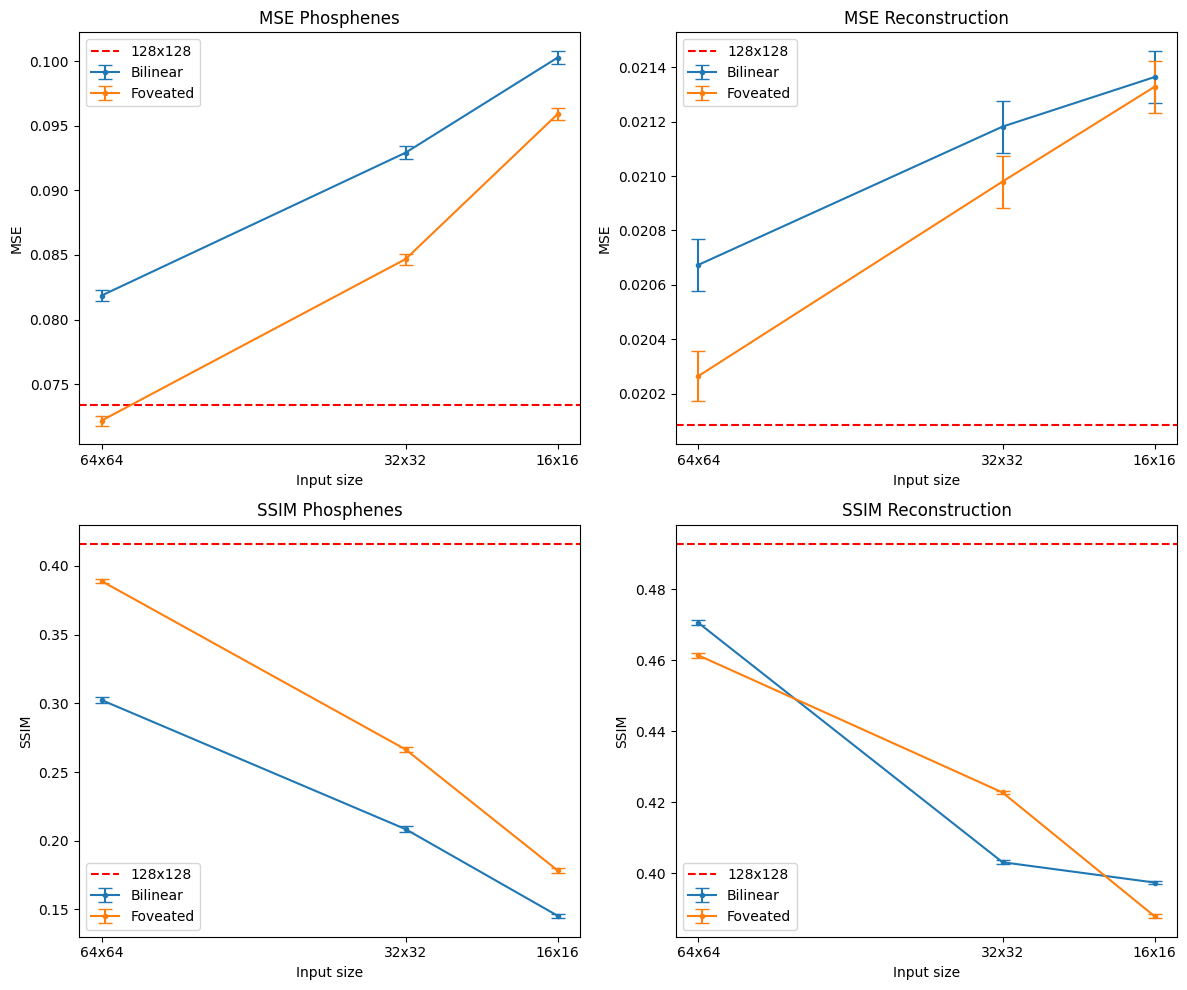

In [10]:
# x axis labels
experiments = ['64x64', '32x32', '16x16']
foveation_types = ['foveated', 'non-foveated']

# Use data from previous cell and split into 64x64lin, 32x32lin, 16x16lin, and 64x64fov, 32x32fov, 16x16fov
baseline = data[data['Experiment'].str.contains('128x128')].copy()
data_lin = data[data['Experiment'].str.contains('lin')].copy()
data_fov = data[data['Experiment'].str.contains('fov')].copy()

# Modify the 'Experiment' column for each dataset
data_lin['Experiment'] = data_lin['Experiment'].str.replace('lin', '')
data_fov['Experiment'] = data_fov['Experiment'].str.replace('fov', '')

# Define custom positions for each input size on a linear scale
input_size_positions = {'64x64': 2, '32x32': 3, '16x16': 3.5}

# Map the 'Experiment' column to these positions
data_lin['Input Size Position'] = data_lin['Experiment'].replace(input_size_positions)
data_fov['Input Size Position'] = data_fov['Experiment'].replace(input_size_positions)

# Calculate mean and standard error for each metric by group
agg_data_lin = data_lin.groupby('Experiment').agg(
    MSE_Phosphenes_mean=('MSE Phosphenes', 'mean'),
    MSE_Phosphenes_err=('MSE Phosphenes', lambda x: x.std() / np.sqrt(len(x))),
    MSE_Reconstruction_mean=('MSE Reconstruction', 'mean'),
    MSE_Reconstruction_err=('MSE Reconstruction', lambda x: x.std() / np.sqrt(len(x))),
    SSIM_Phosphenes_mean=('SSIM Phosphenes', 'mean'),
    SSIM_Phosphenes_err=('SSIM Phosphenes', lambda x: x.std() / np.sqrt(len(x))),
    SSIM_Reconstruction_mean=('SSIM Reconstruction', 'mean'),
    SSIM_Reconstruction_err=('SSIM Reconstruction', lambda x: x.std() / np.sqrt(len(x)))
).reset_index()

agg_data_fov = data_fov.groupby('Experiment').agg(
    MSE_Phosphenes_mean=('MSE Phosphenes', 'mean'),
    MSE_Phosphenes_err=('MSE Phosphenes', lambda x: x.std() / np.sqrt(len(x))),
    MSE_Reconstruction_mean=('MSE Reconstruction', 'mean'),
    MSE_Reconstruction_err=('MSE Reconstruction', lambda x: x.std() / np.sqrt(len(x))),
    SSIM_Phosphenes_mean=('SSIM Phosphenes', 'mean'),
    SSIM_Phosphenes_err=('SSIM Phosphenes', lambda x: x.std() / np.sqrt(len(x))),
    SSIM_Reconstruction_mean=('SSIM Reconstruction', 'mean'),
    SSIM_Reconstruction_err=('SSIM Reconstruction', lambda x: x.std() / np.sqrt(len(x)))
).reset_index()

# Map the positions for plotting
agg_data_lin['Input Size Position'] = agg_data_lin['Experiment'].replace(input_size_positions)
agg_data_fov['Input Size Position'] = agg_data_fov['Experiment'].replace(input_size_positions)

# Create line plots with error bars for the aggregated data
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# MSE Phosphenes
axes[0, 0].axhline(y=baseline['MSE Phosphenes'].mean(), color='r', linestyle='--', label='128x128')
axes[0, 0].errorbar(agg_data_lin['Input Size Position'], agg_data_lin['MSE_Phosphenes_mean'], 
                    yerr=agg_data_lin['MSE_Phosphenes_err'], label="Bilinear", fmt='o-', capsize=5, markersize=3)
axes[0, 0].errorbar(agg_data_fov['Input Size Position'], agg_data_fov['MSE_Phosphenes_mean'], 
                    yerr=agg_data_fov['MSE_Phosphenes_err'], label="Foveated", fmt='o-', capsize=5, markersize=3)
axes[0, 0].legend()
axes[0, 0].set_title('MSE Phosphenes')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].set_xlabel('Input size')
axes[0, 0].set_xticks(list(input_size_positions.values()))
axes[0, 0].set_xticklabels(list(input_size_positions.keys()))

# MSE Reconstruction
axes[0, 1].errorbar(agg_data_lin['Input Size Position'], agg_data_lin['MSE_Reconstruction_mean'], 
                    yerr=agg_data_lin['MSE_Reconstruction_err'], label="Bilinear", fmt='o-', capsize=5, markersize=3)
axes[0, 1].errorbar(agg_data_fov['Input Size Position'], agg_data_fov['MSE_Reconstruction_mean'], 
                    yerr=agg_data_fov['MSE_Reconstruction_err'], label="Foveated", fmt='o-', capsize=5, markersize=3)
axes[0, 1].axhline(y=baseline['MSE Reconstruction'].mean(), color='r', linestyle='--', label='128x128')
axes[0, 1].legend()
axes[0, 1].set_title('MSE Reconstruction')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].set_xlabel('Input size')
axes[0, 1].set_xticks(list(input_size_positions.values()))
axes[0, 1].set_xticklabels(list(input_size_positions.keys()))

# SSIM Phosphenes
axes[1, 0].errorbar(agg_data_lin['Input Size Position'], agg_data_lin['SSIM_Phosphenes_mean'], 
                    yerr=agg_data_lin['SSIM_Phosphenes_err'], label="Bilinear", fmt='o-', capsize=5, markersize=3)
axes[1, 0].errorbar(agg_data_fov['Input Size Position'], agg_data_fov['SSIM_Phosphenes_mean'], 
                    yerr=agg_data_fov['SSIM_Phosphenes_err'], label="Foveated", fmt='o-', capsize=5, markersize=3)
axes[1, 0].axhline(y=baseline['SSIM Phosphenes'].mean(), color='r', linestyle='--', label='128x128')
axes[1, 0].legend()
axes[1, 0].set_title('SSIM Phosphenes')
axes[1, 0].set_ylabel('SSIM')
axes[1, 0].set_xlabel('Input size')
axes[1, 0].set_xticks(list(input_size_positions.values()))
axes[1, 0].set_xticklabels(list(input_size_positions.keys()))

# SSIM Reconstruction
axes[1, 1].errorbar(agg_data_lin['Input Size Position'], agg_data_lin['SSIM_Reconstruction_mean'], 
                    yerr=agg_data_lin['SSIM_Reconstruction_err'], label="Bilinear", fmt='o-', capsize=5, markersize=3)
axes[1, 1].errorbar(agg_data_fov['Input Size Position'], agg_data_fov['SSIM_Reconstruction_mean'], 
                    yerr=agg_data_fov['SSIM_Reconstruction_err'], label="Foveated", fmt='o-', capsize=5, markersize=3)
axes[1, 1].axhline(y=baseline['SSIM Reconstruction'].mean(), color='r', linestyle='--', label='128x128')
axes[1, 1].legend()
axes[1, 1].set_title('SSIM Reconstruction')
axes[1, 1].set_ylabel('SSIM')
axes[1, 1].set_xlabel('Input size')
axes[1, 1].set_xticks(list(input_size_positions.values()))
axes[1, 1].set_xticklabels(list(input_size_positions.keys()))

plt.tight_layout()
plt.show()


In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Flatten data and create labels
mse_phosphene_values = []
ssim_phosphene_values = []
mse_reconstruction_values = []
ssim_reconstruction_values = []

model_labels = []

for model, values in model_outputs_.items():
    mse_phosphene_values.extend(values['mse_phosphenes'])
    ssim_phosphene_values.extend(values['ssim_phosphenes'])
    mse_reconstruction_values.extend(values['mse_reconstruction'])
    ssim_reconstruction_values.extend(values['ssim_reconstruction'])
    model_labels.extend([model] * len(values['mse_phosphenes']))

# Perform Tukey's HSD test
tukey_mse_phosphene = pairwise_tukeyhsd(mse_phosphene_values, model_labels)
tukey_ssim_phosphene = pairwise_tukeyhsd(ssim_phosphene_values, model_labels)
tukey_mse_reconstruction = pairwise_tukeyhsd(mse_reconstruction_values, model_labels)
tukey_ssim_reconstruction = pairwise_tukeyhsd(ssim_reconstruction_values, model_labels)

In [28]:
print(tukey_mse_phosphene)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
 128x128 16x16fov   0.0225    0.0  0.0206  0.0244   True
 128x128 16x16lin   0.0269    0.0   0.025  0.0288   True
 128x128 32x32fov   0.0113    0.0  0.0094  0.0132   True
 128x128 32x32lin   0.0195    0.0  0.0176  0.0214   True
 128x128 64x64fov  -0.0012 0.4678 -0.0031  0.0007  False
 128x128 64x64lin   0.0085    0.0  0.0066  0.0103   True
16x16fov 16x16lin   0.0044    0.0  0.0025  0.0063   True
16x16fov 32x32fov  -0.0112    0.0 -0.0131 -0.0093   True
16x16fov 32x32lin   -0.003 0.0001 -0.0049 -0.0011   True
16x16fov 64x64fov  -0.0237    0.0 -0.0256 -0.0219   True
16x16fov 64x64lin  -0.0141    0.0 -0.0159 -0.0122   True
16x16lin 32x32fov  -0.0156    0.0 -0.0175 -0.0137   True
16x16lin 32x32lin  -0.0074    0.0 -0.0092 -0.0055   True
16x16lin 64x64fov  -0.0281    0.0   -0.03 -0.0262   True
16x16lin 64x64lin  -0.0184    0

In [29]:
print(tukey_ssim_phosphene)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
 128x128 16x16fov  -0.2379   0.0 -0.2457 -0.2301   True
 128x128 16x16lin  -0.2708   0.0 -0.2786 -0.2631   True
 128x128 32x32fov  -0.1498   0.0 -0.1576 -0.1421   True
 128x128 32x32lin  -0.2078   0.0 -0.2156 -0.2001   True
 128x128 64x64fov  -0.0273   0.0 -0.0351 -0.0195   True
 128x128 64x64lin  -0.1139   0.0 -0.1216 -0.1061   True
16x16fov 16x16lin  -0.0329   0.0 -0.0407 -0.0252   True
16x16fov 32x32fov   0.0881   0.0  0.0803  0.0958   True
16x16fov 32x32lin   0.0301   0.0  0.0223  0.0378   True
16x16fov 64x64fov   0.2106   0.0  0.2028  0.2183   True
16x16fov 64x64lin    0.124   0.0  0.1163  0.1318   True
16x16lin 32x32fov    0.121   0.0  0.1132  0.1288   True
16x16lin 32x32lin    0.063   0.0  0.0552  0.0708   True
16x16lin 64x64fov   0.2435   0.0  0.2358  0.2513   True
16x16lin 64x64lin   0.1569   0.0  0.1492  0.1647

In [30]:
print(tukey_mse_reconstruction)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
 128x128 16x16fov   0.0012    0.0  0.0008  0.0016   True
 128x128 16x16lin   0.0013    0.0  0.0009  0.0017   True
 128x128 32x32fov   0.0009    0.0  0.0005  0.0013   True
 128x128 32x32lin   0.0011    0.0  0.0007  0.0015   True
 128x128 64x64fov   0.0002 0.8231 -0.0002  0.0006  False
 128x128 64x64lin   0.0006 0.0002  0.0002   0.001   True
16x16fov 16x16lin      0.0    1.0 -0.0004  0.0004  False
16x16fov 32x32fov  -0.0003 0.1247 -0.0007     0.0  False
16x16fov 32x32lin  -0.0001 0.9299 -0.0005  0.0002  False
16x16fov 64x64fov  -0.0011    0.0 -0.0015 -0.0007   True
16x16fov 64x64lin  -0.0007    0.0  -0.001 -0.0003   True
16x16lin 32x32fov  -0.0004 0.0623 -0.0008     0.0  False
16x16lin 32x32lin  -0.0002 0.8223 -0.0006  0.0002  False
16x16lin 64x64fov  -0.0011    0.0 -0.0015 -0.0007   True
16x16lin 64x64lin  -0.0007    0

In [31]:
print(tukey_ssim_reconstruction)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
 128x128 16x16fov  -0.1049   0.0 -0.1074 -0.1024   True
 128x128 16x16lin  -0.0954   0.0 -0.0979 -0.0929   True
 128x128 32x32fov    -0.07   0.0 -0.0725 -0.0675   True
 128x128 32x32lin  -0.0897   0.0 -0.0922 -0.0872   True
 128x128 64x64fov  -0.0315   0.0  -0.034  -0.029   True
 128x128 64x64lin  -0.0223   0.0 -0.0248 -0.0198   True
16x16fov 16x16lin   0.0095   0.0   0.007   0.012   True
16x16fov 32x32fov   0.0348   0.0  0.0323  0.0373   True
16x16fov 32x32lin   0.0152   0.0  0.0127  0.0177   True
16x16fov 64x64fov   0.0734   0.0  0.0709  0.0759   True
16x16fov 64x64lin   0.0825   0.0    0.08   0.085   True
16x16lin 32x32fov   0.0253   0.0  0.0228  0.0278   True
16x16lin 32x32lin   0.0057   0.0  0.0032  0.0082   True
16x16lin 64x64fov   0.0639   0.0  0.0614  0.0664   True
16x16lin 64x64lin    0.073   0.0  0.0705  0.0756

## Poster vis

In [14]:
# indices = [12, 11, 16, 17]
# example_images = [DataLoader(testset, batch_size=4).dataset[i] for i in indices]
# example_images = {key: torch.stack([example_images[i][key] for i in range(4)]) for key in example_images[0].keys()}

# # show example_images
# fig, axs = plt.subplots(1, 4, figsize=(15, 15))
# # remove white space completely
# fig.subplots_adjust(wspace=0.01, hspace=0.01)

# for i in range(4):
#     axs[i].imshow(example_images['image'][i].permute(1,2,0).cpu(), interpolation='none')
#     axs[i].axis('off')

# plt.show()


In [15]:
experiments = ['128x128', '64x64lin', '64x64fov', '32x32lin', '32x32fov', '16x16lin', '16x16fov']

model_outputs = {}

indices = [569, 835, 581, 1692]
# save model_output for all for one batch 

for experiment in experiments:
    cfg = config[experiment]
    testset = local_datasets.get_lapa_dataset(cfg, split='test')
    models = init_training.get_models(cfg)

    models['encoder'].load_state_dict(torch.load(cfg['save_path'] + 'checkpoints/final_encoder.pth'))
    models['decoder'].load_state_dict(torch.load(cfg['save_path'] + 'checkpoints/final_decoder.pth'))

    # The forward function
    training_pipeline = init_training.get_training_pipeline(cfg)

    forward = training_pipeline['forward']
    compound_loss_func = training_pipeline['compound_loss_func']

    example_images = [DataLoader(testset, batch_size=4).dataset[i] for i in indices]
    example_images = {key: torch.stack([example_images[i][key] for i in range(4)]) for key in example_images[0].keys()} 

    with torch.no_grad():
        model_output = forward(example_images, models, cfg)
        # if model_output['input'].shape[2] == 64: # add background
        #     background = torch.ones((4, 3, 128, 128))
        #     background[:,:,64-32:64+32,64-32:64+32] = model_output['input']
        #     model_output['input'] = background
        model_outputs[experiment] = model_output   


# Get 256x256 images from the test set
config['256x256'] = config['128x128'].copy()
config['256x256']['imsize'] = [256, 256]
testset = local_datasets.get_lapa_dataset(config['256x256'], split='test')

# Get the first 4 images from the test set
example_images_256 = [testset[i] for i in indices]
example_images_256 = {key: torch.stack([example_images_256[i][key] for i in range(4)]) for key in example_images_256[0].keys()}


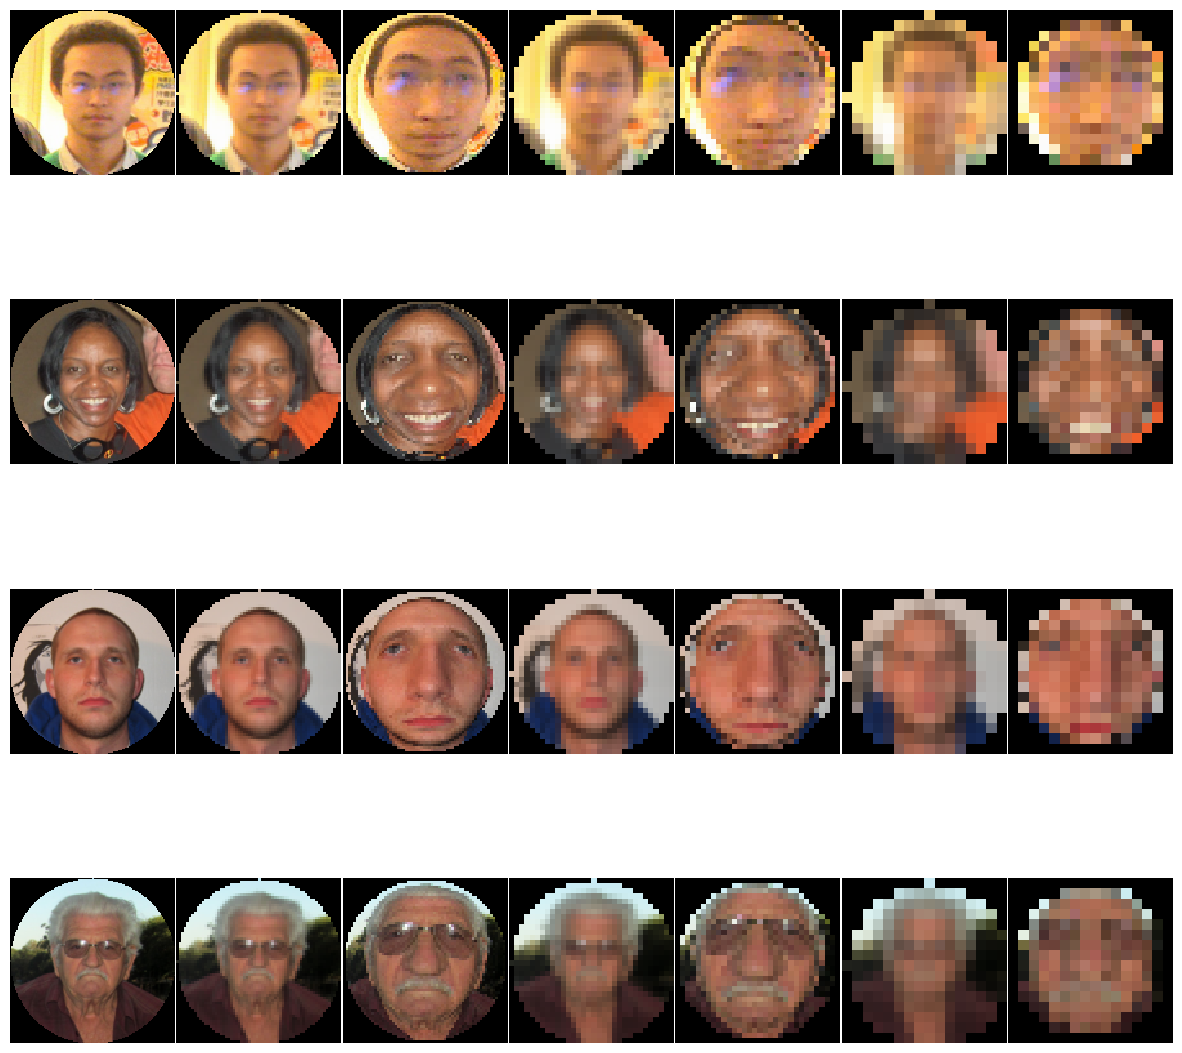

In [16]:
# plot first 16 images of the test set
fig, axs = plt.subplots(4, len(experiments), figsize=(15, 15))
# remove white space completely
fig.subplots_adjust(wspace=0.01, hspace=0.01)

for i in range(4):
    for j in range(len(experiments)):
        axs[i,j].imshow(model_outputs[experiments[j]]['input'][i].permute(1,2,0).squeeze().cpu(), interpolation='none')
        axs[i,j].axis('off')

plt.show()


In [20]:
experiment_names = ['128x128 (Baseline)', '64x64 (Bilinear)', '64x64 (Foveated)', '32x32 (Bilinear)', '32x32 (Foveated)', '16x16 (Bilinear)', '16x16 (Foveated)']

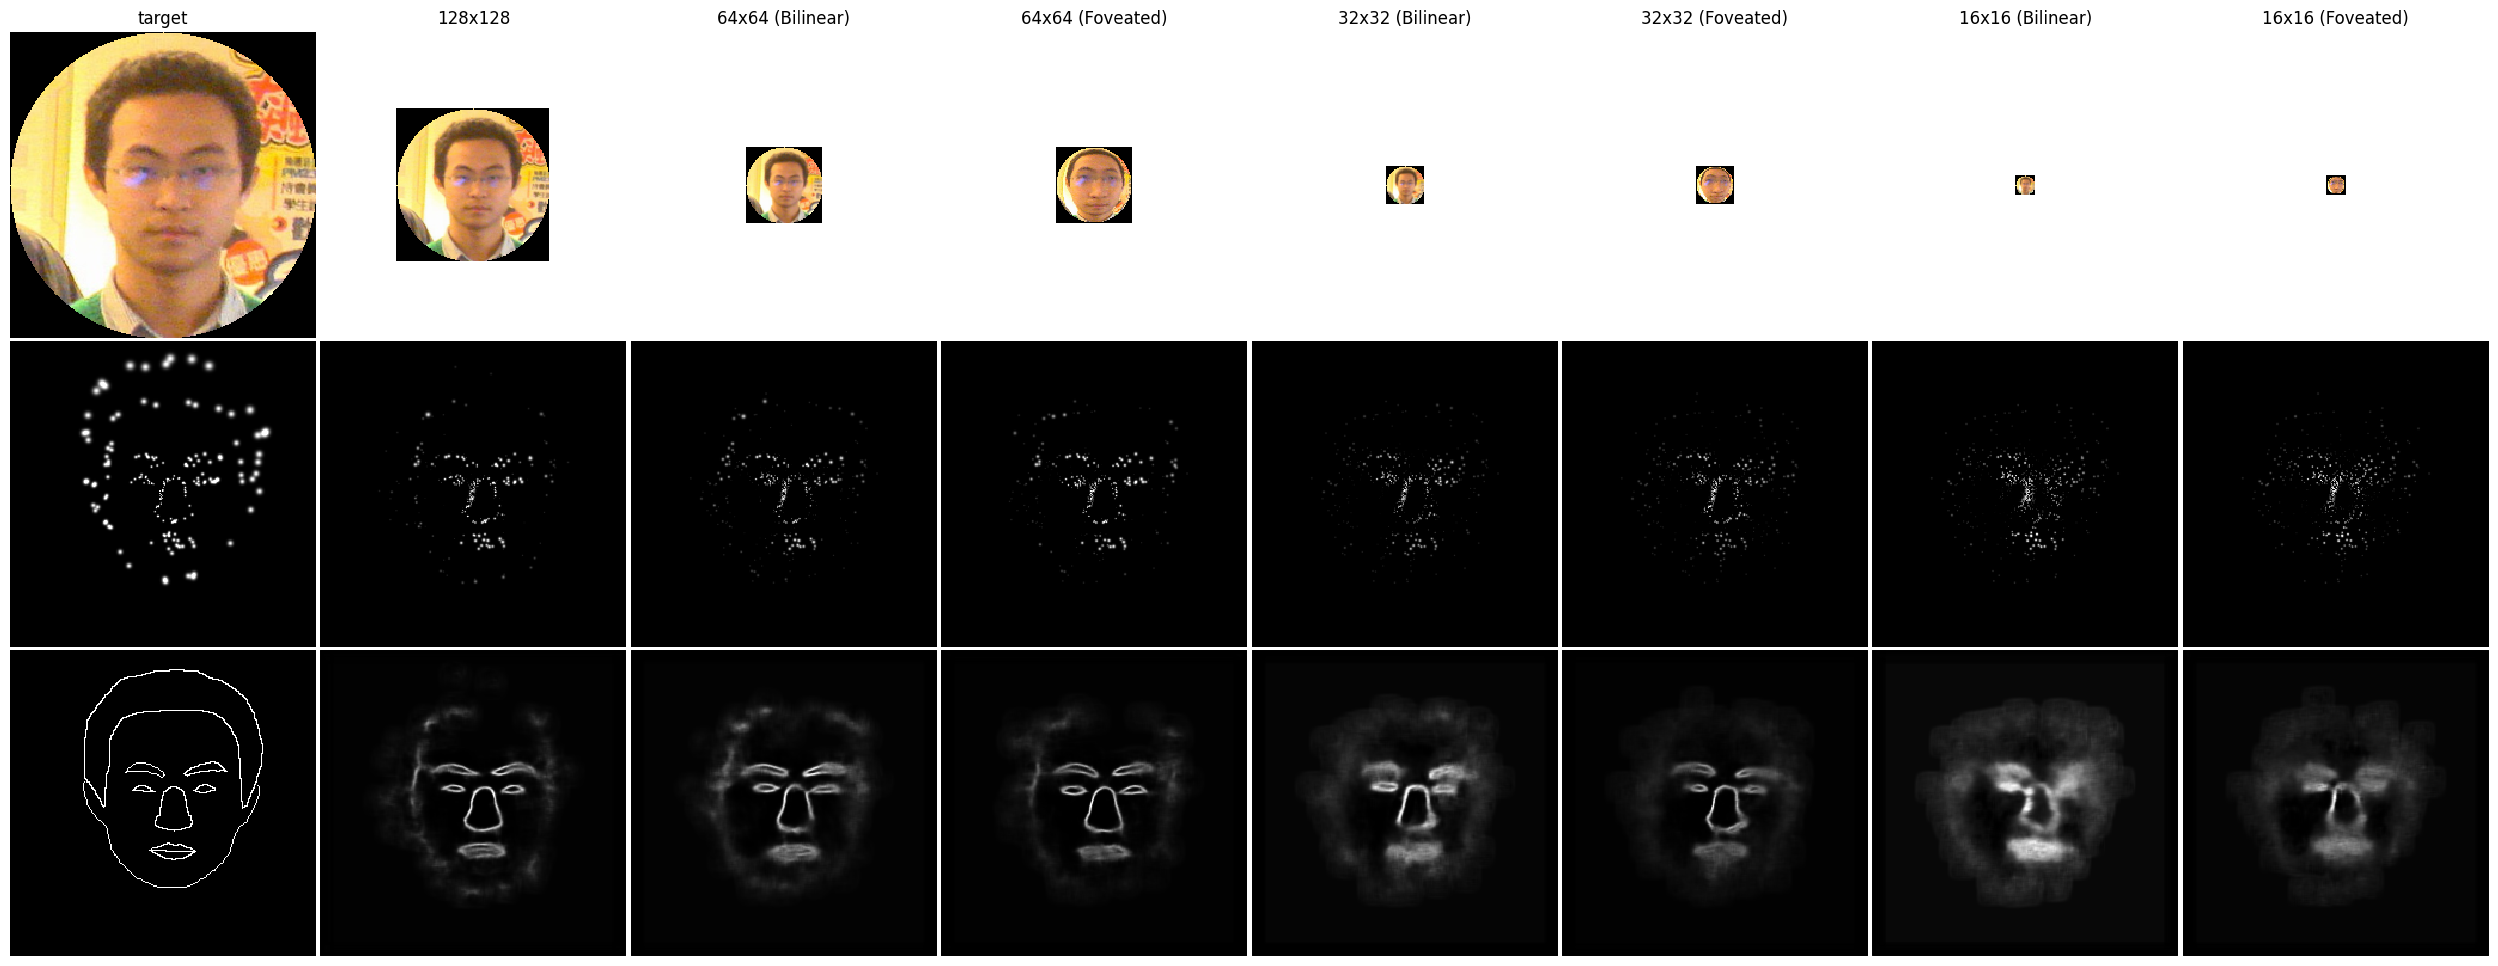

In [18]:
# now the same including input RGBimage ['input']
# figsize such that images are 256 x 256
fig, axs = plt.subplots(3, 8, figsize=(32, 12))
# remove white space completely
fig.subplots_adjust(wspace=0.01, hspace=0.01)

image_index = 0
fontsize = 12

# ground truth
axs[0,0].set_title('target', fontsize=12)
axs[0,0].imshow(example_images_256['image'][image_index].permute(1,2,0).cpu(), interpolation='none')
axs[0,0].axis('off')

axs[1,0].imshow(model_outputs[experiments[0]]['target_phosphenes'][image_index][0].cpu(), cmap='gray', interpolation='none')
axs[1,0].axis('off')

axs[2,0].imshow(model_outputs[experiments[0]]['target'][image_index][0].cpu(), cmap='gray', interpolation='none')
axs[2,0].axis('off')

for i, experiment in enumerate(experiments):
    # title
    axs[0,i+1].set_title(experiment_names[i], fontsize=fontsize)
    # axs[0,i+1].imshow(model_outputs[experiment]['input'][image_index].permute(1,2,0).cpu(), interpolation='none')
    # Plot images in their true size
    # Add padding to the input image
    image_size = model_outputs[experiment]['input'][image_index].shape[-1]
    background = torch.ones((3, 256, 256))
    background[:,128-image_size//2:128+image_size//2,128-image_size//2:128+image_size//2] = model_outputs[experiment]['input'][image_index]
    axs[0,i+1].imshow(background.permute(1,2,0).cpu(), interpolation='none')

    axs[0,i+1].axis('off')

    axs[1,i+1].imshow(model_outputs[experiment]['phosphenes'][image_index][0].cpu(), cmap='gray', interpolation='none')
    axs[1,i+1].axis('off')

    axs[2,i+1].imshow(model_outputs[experiment]['reconstruction'][image_index][0].cpu(), cmap='gray', interpolation='none')
    axs[2,i+1].axis('off')

plt.show()

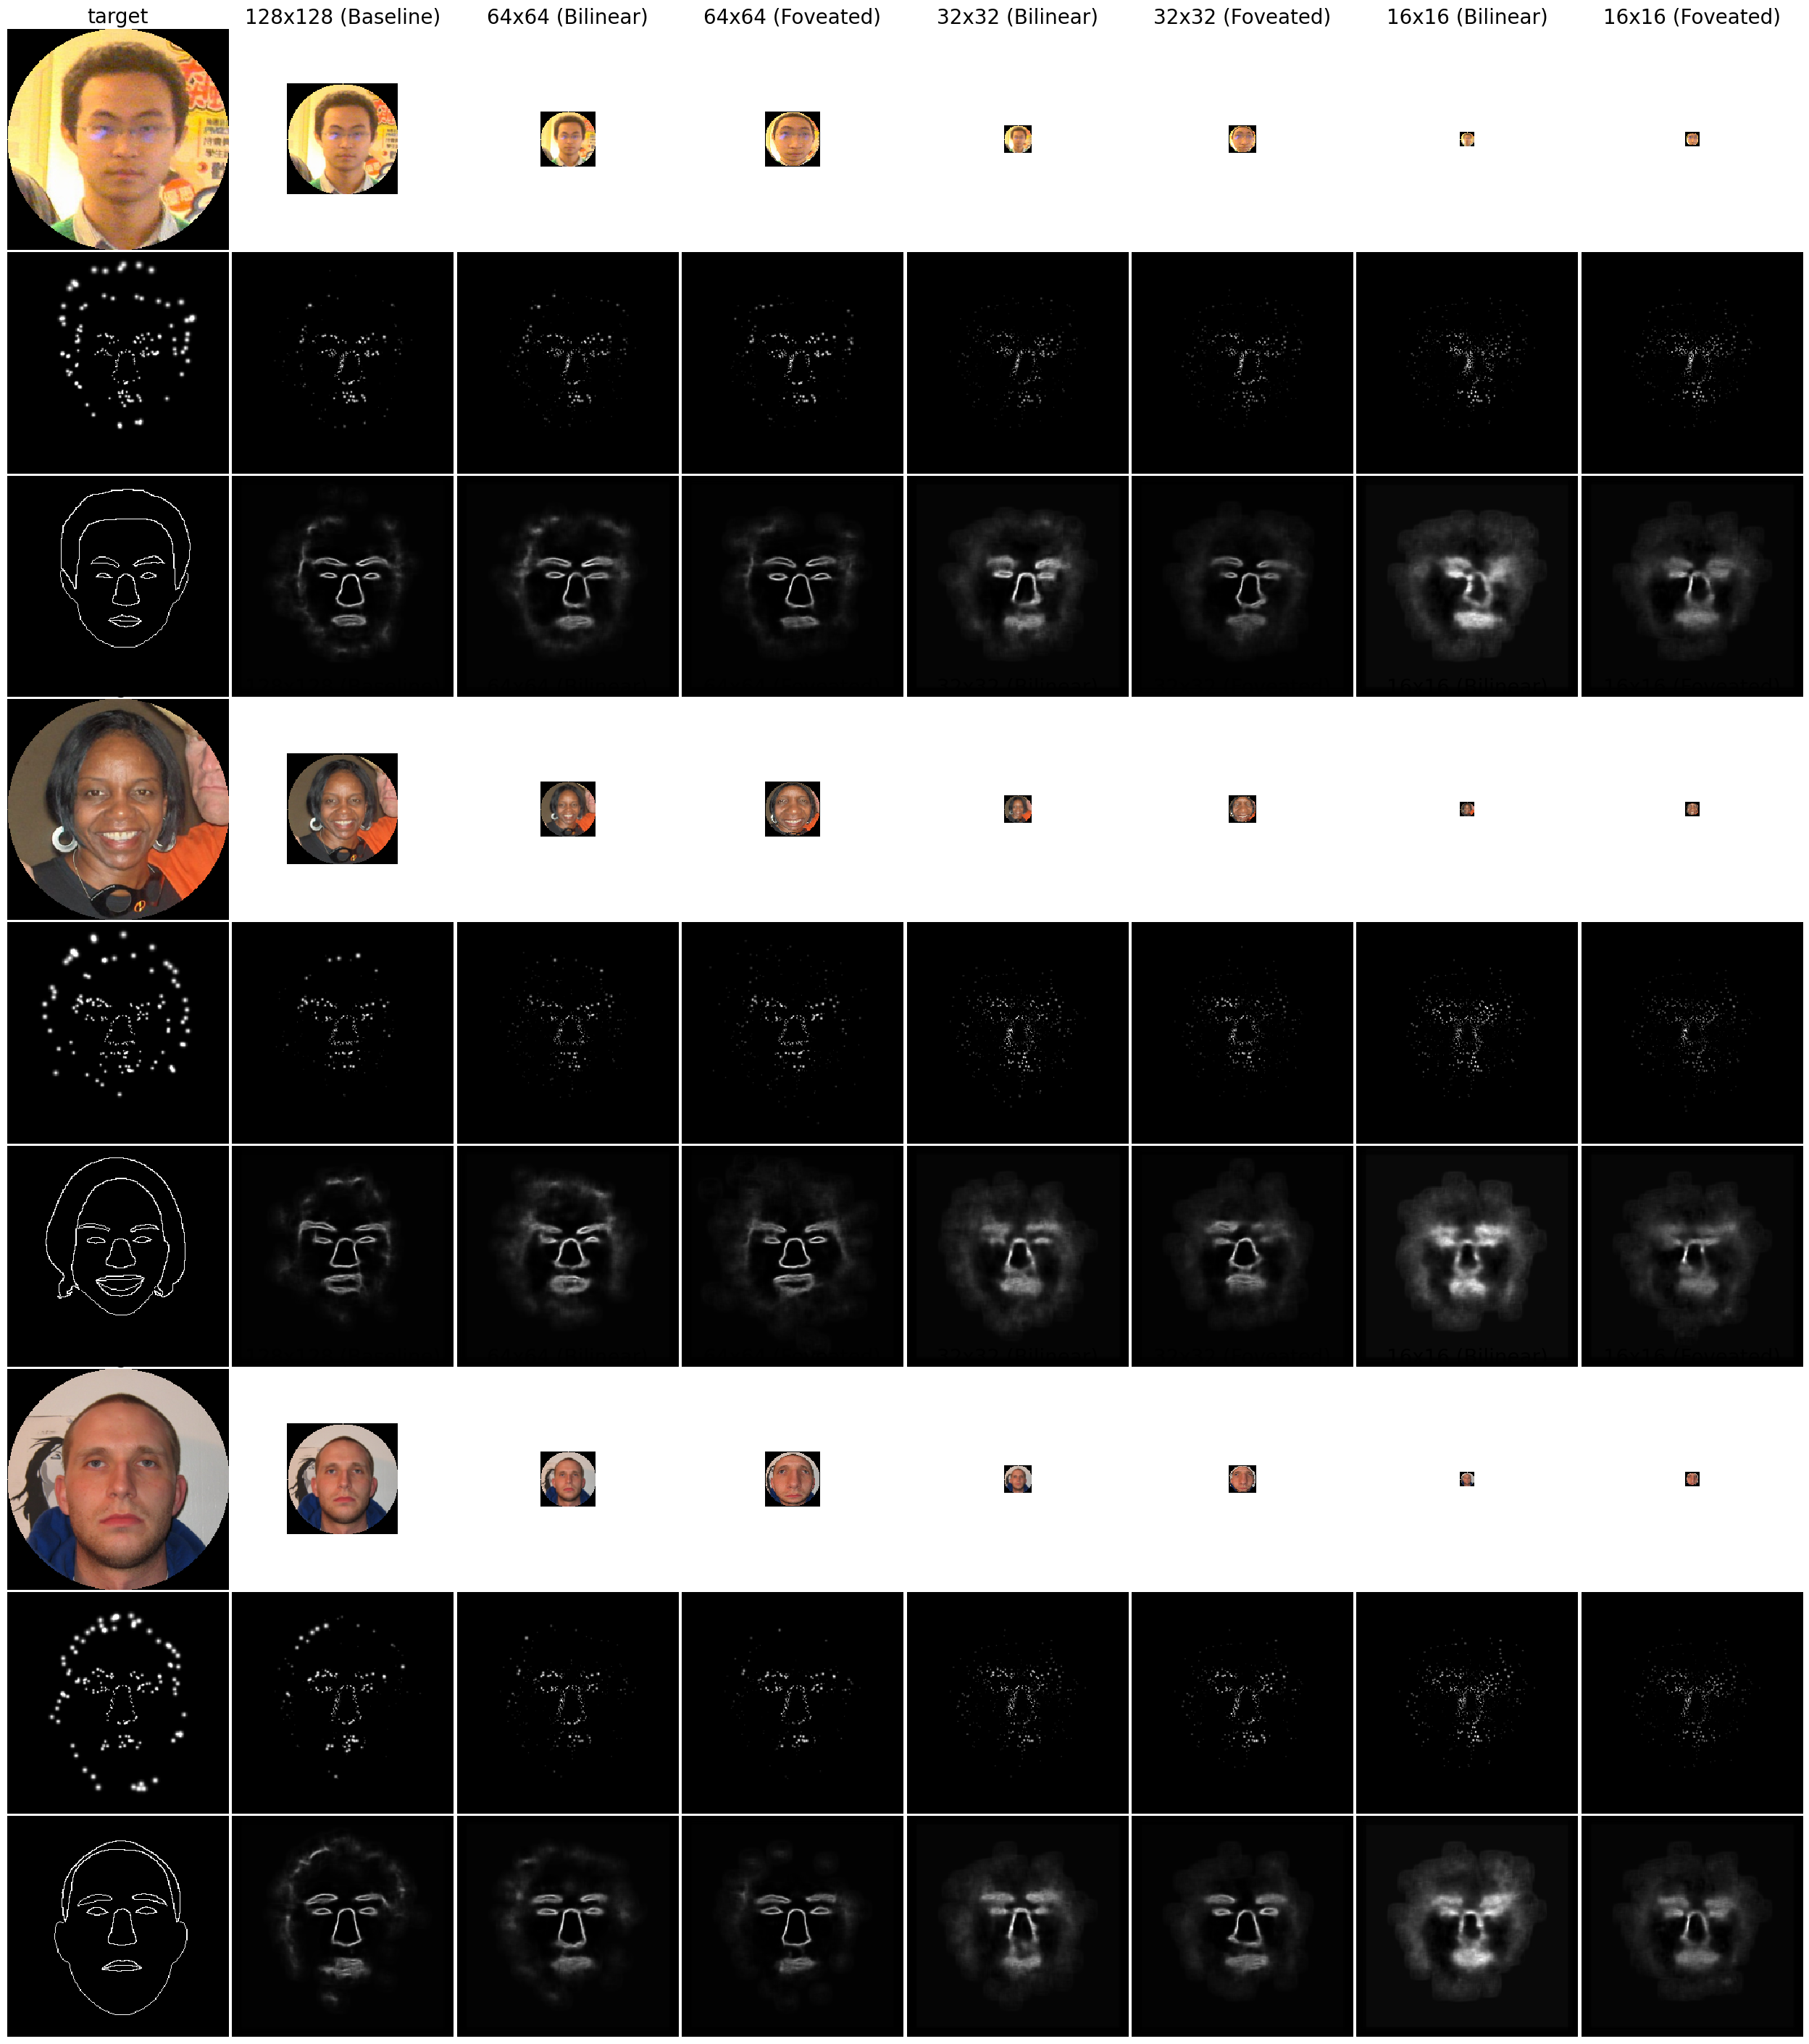

In [21]:
# now the same but for 3 images underneath each other
fig, axs = plt.subplots(9, 8, figsize=(32, 36))
# remove white space completely
fig.subplots_adjust(wspace=0.01, hspace=0.01)

# use image_indices
fontsize = 20
for i, image_index in enumerate(indices[:3]):
    # ground truth
    axs[3*i,0].set_title('target', fontsize=fontsize)
    axs[3*i,0].imshow(example_images_256['image'][i].permute(1,2,0).cpu(), interpolation='none')
    axs[3*i,0].axis('off')

    axs[3*i+1,0].imshow(model_outputs[experiments[0]]['target_phosphenes'][i][0].cpu(), cmap='gray', interpolation='none')
    axs[3*i+1,0].axis('off')

    axs[3*i+2,0].imshow(model_outputs[experiments[0]]['target'][i][0].cpu(), cmap='gray', interpolation='none')
    axs[3*i+2,0].axis('off')

    for j, experiment in enumerate(experiments):
        # title
        axs[3*i,j+1].set_title(experiment_names[j], fontsize=fontsize)
        # axs[0,i+1].imshow(model_outputs[experiment]['input'][image_index].permute(1,2,0).cpu(), interpolation='none')
        # Plot images in their true size
        # Add padding to the input image
        image_size = model_outputs[experiment]['input'][i].shape[-1]
        background = torch.ones((3, 256, 256))
        background[:,128-image_size//2:128+image_size//2,128-image_size//2:128+image_size//2] = model_outputs[experiment]['input'][i]
        axs[3*i,j+1].imshow(background.permute(1,2,0).cpu(), interpolation='none')

        axs[3*i,j+1].axis('off')

        axs[3*i+1,j+1].imshow(model_outputs[experiment]['phosphenes'][i][0].cpu(), cmap='gray', interpolation='none')
        axs[3*i+1,j+1].axis('off')

        axs[3*i+2,j+1].imshow(model_outputs[experiment]['reconstruction'][i][0].cpu(), cmap='gray', interpolation='none')
        axs[3*i+2,j+1].axis('off')

plt.show()